# Numero de revisiones 

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

Import Lista planillas 

In [5]:
lista_planillas=pd.read_csv('Lista_planillas_COMPLETE.csv',
                            index_col=0,
                            parse_dates=['Fecha'],
                            infer_datetime_format=True)


Import Lista detalles

In [6]:
# Importar planillas de detalles
planilla_detalles=pd.read_csv('DATASET/0.0.planillas.detalle.COMPLETE.csv',
                              index_col='Planilla',
                              dtype={'Modelo':'Int64','Planilla':'Int64'})


Import lista historico de revisiones 

In [7]:
historico_revisiones=pd.read_csv('DATASET/0.0.planillas.hist.COMPLETE.csv',
                                 index_col='Planilla',
                                 parse_dates=['Fecha'],
                                 infer_datetime_format=True)


# Data Cleaning 

Lista de detalles

In [8]:
#Eliminar filas vacias
planilla_detalles.dropna(inplace=True)

#Cambiar nombre columnas
planilla_detalles.rename(columns={'Dominio:':'Dominio','Convenio:':'Convenio'},inplace=True)

#Eliminar columna innecesaria
planilla_detalles.drop(columns='Unnamed: 0',inplace=True)

lista historio de revisones

In [9]:
#Eliminar columna innecesaria
historico_revisiones.drop(columns='Unnamed: 0',inplace=True)

Lista de planillas

<AxesSubplot:>

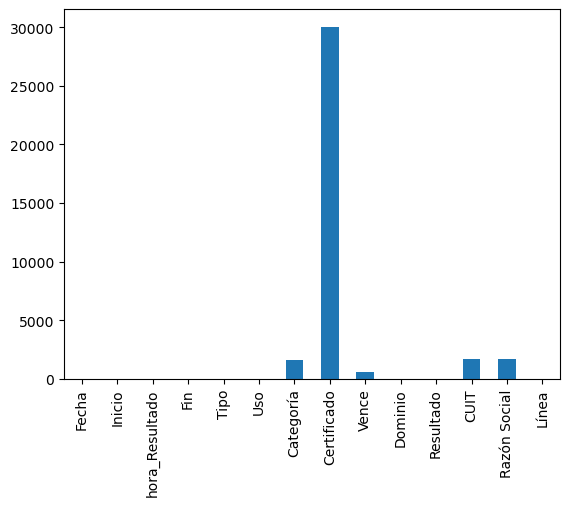

In [10]:
lista_planillas.isna().sum().plot(kind='bar')

In [11]:

#Crear Columnas : Anio,Mes,Mes_label, Anio y mes 
lista_planillas['Anio']=lista_planillas['Fecha'].dt.year

lista_planillas['Mes']=lista_planillas['Fecha'].dt.month

lista_planillas['Mes_label']=lista_planillas['Fecha'].dt.month_name(locale='es_ES')

lista_planillas['Anio y Mes']=lista_planillas['Anio'].astype(str)+lista_planillas['Mes'].astype(str)

# Mostrar CUIT en formato correcto 
lista_planillas['CUIT']=lista_planillas['CUIT'].astype('Int64')
#pd.options.display.float_format = '{:.0f}'.format

# Borrar espacios de Razon Social  
lista_planillas['Razón Social']=lista_planillas['Razón Social'].str.replace('\W', ' ', regex=True)

# Borrar asteriscos de Dominio
lista_planillas['Dominio']=lista_planillas['Dominio'].str.replace('\W', ' ', regex=True)




Establecer una unica Razon Social para cada CUIT: 

Por errores de data entry, hay varios valores de razon social para un mismo CUIT. 

In [12]:
#Eliminar Cuit repetidos:
df_cuit_razon_social=lista_planillas[['CUIT','Razón Social']].drop_duplicates(subset=['CUIT']).sort_values('CUIT') 

#Usar CUIT como index
df_cuit_razon_social.set_index('CUIT',inplace=True)


#Transponer dataframe y pasarlo a lista de valores en el formato [{CUIT:Razon Social,CUIT:Razon Social}]
list_dict_cuit_razon_social=df_cuit_razon_social.T.to_dict(orient='records')


#El dicionario esta dentro de la lista, seleccionamos el indice [0] de la lista para obtenerlo
dict_cuit_razon_social=list_dict_cuit_razon_social[0]


In [15]:
#Creamos columna Razon Social Unica. Mapeamos los valores desde el diccionario 
lista_planillas['Razón Social Unica']=lista_planillas['CUIT'].map(dict_cuit_razon_social)

# Agregar Modelo a lista de planillas

In [16]:
#planilla de key : Dominio : Modelo 
planilla_detalles_key=planilla_detalles[['Modelo','Dominio']].drop_duplicates(subset=['Dominio'])

# Agregar con left merge 
lista_planillas_completa=lista_planillas.merge(planilla_detalles_key,how='left',left_on='Dominio',right_on='Dominio')


In [17]:
#Agregar antiguedad al momento de la revision 
lista_planillas_completa['antiguedad_revision']=lista_planillas_completa['Anio']-lista_planillas_completa['Modelo']

# Agregar columna Planilla&Dominio
Para tener como unique key y/o index depende de las necesidades

Agrego esta columna en todas las planillas

In [18]:
lista_planillas['Planilla&Dominio']=lista_planillas.index.astype(str)+lista_planillas['Dominio']

planilla_detalles['Planilla&Dominio']=planilla_detalles.index.astype(str)+planilla_detalles['Dominio']

historico_revisiones['Planilla&Dominio']=historico_revisiones.index.astype(str)+historico_revisiones['Dominio']


# Eliminar duplicados 

In [19]:
lista_planillas.drop_duplicates(subset=('Planilla&Dominio'),inplace=True)

planilla_detalles.drop_duplicates(subset=('Planilla&Dominio'),inplace=True)

historico_revisiones.drop_duplicates(subset=('Planilla&Dominio'),inplace=True)

# Flota total de cada Empresa

In [20]:
#Eliminamos los duplicados de los pares Patente-CUIT . una misma patente pudo ser transferida por lo que si borramos todos los duplicados de patentes perderiamos esa informacion 
lista_planillas_dominio=lista_planillas.drop_duplicates(subset=['Dominio','CUIT'])

#Creamos una planilla agrupando y contando los dominios por Razon Social Unica.
vehiculos_por_cliente=lista_planillas_dominio.groupby('Razón Social Unica')[['Dominio']].count()

#Cambiamos el nombre de la columna por uno mas adecuado Revisiones Totales
vehiculos_por_cliente.rename(columns={'Dominio':'Flota Historica'},inplace=True)

#Ordenamos los Clientes  por mayor numero de Revisiones totales 
vehiculos_por_cliente.sort_values('Flota Historica',ascending=False).head(10)

,Flota Historica
Razón Social Unica,
AMARILLA GAS S A,383
ERSA URBANO S A,287
ADOLFO SARTORI S A,286
TELECOM ARGENTINA S A,263
NUEVO BANCO DEL CHACO S A,170
CARSA S A,113
EMPRESA TIRO FEDERAL RCIA S R L,110
DERUDDER HOS S R L FLECHA BUS,103
ERSA CHACO S A,100


# Mejores clientes Historico

In [21]:
#Creamos una planilla agrupando y contando los dominios por Razon Social Unica.
vehiculos_por_cliente=lista_planillas.groupby('Razón Social Unica')[['Dominio']].count()

#Cambiamos el nombre de la columna por uno mas adecuado Revisiones Totales
vehiculos_por_cliente.rename(columns={'Dominio':'Revisiones Totales'},inplace=True)

#Ordenamos los Clientes  por mayor numero de Revisiones totales 
vehiculos_por_cliente.sort_values('Revisiones Totales',ascending=False).head(10)

,Revisiones Totales
Razón Social Unica,
ERSA URBANO S A,1107
ADOLFO SARTORI S A,1062
AMARILLA GAS S A,1026
EMPRESA TIRO FEDERAL RCIA S R L,984
ERSA CHACO S A,689
TELECOM ARGENTINA S A,667
SAN FERNANDO URBANOS S R L,651
EMPRESA LA TERMAL S R L,464
EMPRESA LA ESTRELLA S A,458


# Mejores clientes por año 

In [22]:
vehiculos_por_cliente_anual=pd.pivot_table(lista_planillas,index='Razón Social Unica',values='CUIT',columns='Anio',aggfunc='count')

In [23]:
#reemplazo na por 0
vehiculos_por_cliente_anual.fillna(0,inplace=True)

In [24]:
vehiculos_por_cliente_anual.sort_values(2022,ascending=False).head(10)

Anio,2014,2015,2016,2017,2018,2019,2020,2021,2022
Razón Social Unica,,,,,,,,,
ERSA URBANO S A,17.0,29.0,44.0,65.0,135.0,239.0,140.0,223.0,215.0
AMARILLA GAS S A,14.0,87.0,92.0,109.0,110.0,122.0,163.0,176.0,153.0
ADOLFO SARTORI S A,24.0,125.0,125.0,142.0,117.0,134.0,127.0,133.0,135.0
EMPRESA TIRO FEDERAL RCIA S R L,35.0,116.0,131.0,147.0,131.0,126.0,88.0,114.0,96.0
TELECOM ARGENTINA S A,22.0,61.0,93.0,89.0,70.0,76.0,70.0,91.0,95.0
INDUSTRIAL Y CONSTRUCTORA S A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,75.0
SAN FERNANDO URBANOS S R L,21.0,135.0,138.0,84.0,67.0,54.0,43.0,48.0,61.0
LA CORDIAL S R L,6.0,62.0,55.0,50.0,67.0,51.0,52.0,50.0,56.0
EMPRESA LA TERMAL S R L,8.0,36.0,58.0,80.0,77.0,78.0,32.0,43.0,52.0


Ranking Mejores clientes por año 

In [25]:
#Lista de Empresas que fueron top en algun año 
lt=[]
for a in range (2014,2023):
    l=vehiculos_por_cliente_anual.nlargest(5,a).index.tolist()
    lt=lt+l
lt=set(lt)
#lt=[elem[:20]for elem  in lt]
lt=list(lt)


<AxesSubplot:xlabel='Anio'>

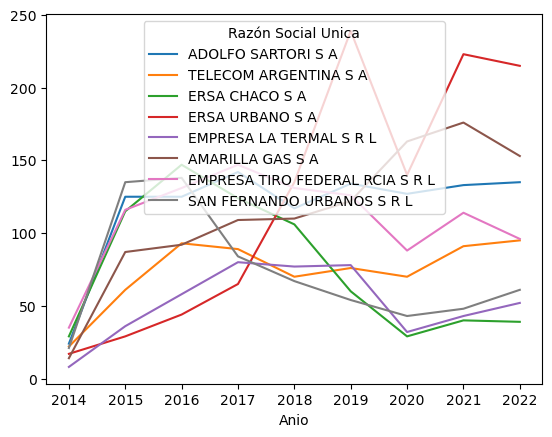

In [26]:
# Transpongo la tabla para tener la fecha de index
#Filtro la tabla con la lista de empresas que fueron top 5 en algun año
vehiculos_por_cliente_anual_t=vehiculos_por_cliente_anual.loc[lt].T
vehiculos_por_cliente_anual_t.plot(kind='line')

Ranking Mejores clientes Acumulado

In [27]:
#Tabla pivot usando pd.grouper para agrupar mensualmente en la columna FECHA
vehiculos_por_cliente_mensual=pd.pivot_table(lista_planillas,index='Razón Social Unica',values='CUIT',columns=pd.Grouper(key='Fecha',freq='M'),aggfunc='count')

In [28]:
#reemplazo na por 0
vehiculos_por_cliente_mensual.fillna(0,inplace=True)

In [29]:
#Lista de Empresas que fueron top en algun año
lt=[]
for a in range (2014,2023):
    l=vehiculos_por_cliente_anual.nlargest(12,a).index.tolist()
    lt=lt+l
lt=set(lt)
#lt=[elem[:20]for elem  in lt]
lt=list(lt)


In [30]:
# Transpongo la tabla para tener la fecha de index 
#Filtro la tabla con la lista de empresas que fueron top 12 en algun año
vehiculos_por_cliente_mensual_t=vehiculos_por_cliente_mensual.loc[lt].T

In [31]:
# Uso CUMSUM para obtener el total de revisiones hasta la fecha de cada empresa

vehiculos_por_cliente_mensual_sum=vehiculos_por_cliente_mensual_t.cumsum(axis=0)

In [32]:
#Ordeno por fecha
vehiculos_por_cliente_mensual_sum.sort_index(inplace=True)

In [33]:
#Filtrar año >=2015
vehiculos_por_cliente_mensual_sum.loc['2015-01-01':]

Razón Social Unica,EMPRESA LA ESTRELLA S A,DIRECCIÓN NACIONAL DE VIALIDAD,EMPRESA TIRO FEDERAL RCIA S R L,SAN FERNANDO URBANOS S R L,HIJOS DE ROBERTO CANCIO DEMONTE S A,CETROGAR S A,ERSA CHACO S A,MELLI HNOS S A,EMPRESA LA TERMAL S R L,LA CORDIAL S R L,...,NELSON MELLI CONSTRUCCIONES S A C I C I Y F,ADOLFO SARTORI S A,FABRICA S R L,DERUDDER HOS S R L FLECHA BUS,CASA GAONA S A,AMARILLA GAS S A,TECSA S R L,INDUSTRIAL Y CONSTRUCTORA S A,SNAIDER OMAR ALBERTO,DOLZANI HNOS DOLZANI R MARIO Y DOLZANI O RUBEN S H
Fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-31,19.0,18.0,49.0,28.0,11.0,7.0,34.0,7.0,10.0,12.0,...,17.0,31.0,6.0,5.0,9.0,23.0,2.0,0.0,16.0,12.0
2015-02-28,22.0,19.0,55.0,36.0,12.0,8.0,48.0,7.0,13.0,22.0,...,20.0,39.0,9.0,10.0,11.0,29.0,2.0,0.0,23.0,13.0
2015-03-31,29.0,19.0,61.0,46.0,14.0,8.0,54.0,7.0,18.0,26.0,...,20.0,52.0,12.0,13.0,11.0,37.0,2.0,0.0,26.0,16.0
2015-04-30,42.0,22.0,75.0,57.0,16.0,9.0,64.0,10.0,23.0,33.0,...,23.0,67.0,15.0,15.0,11.0,45.0,2.0,0.0,26.0,22.0
2015-05-31,49.0,22.0,92.0,63.0,18.0,12.0,84.0,10.0,25.0,34.0,...,24.0,74.0,18.0,20.0,13.0,60.0,6.0,0.0,30.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,446.0,39.0,951.0,635.0,162.0,243.0,678.0,244.0,446.0,425.0,...,278.0,1007.0,165.0,176.0,286.0,978.0,181.0,78.0,295.0,205.0
2022-09-30,447.0,39.0,966.0,636.0,162.0,248.0,682.0,245.0,451.0,429.0,...,282.0,1020.0,165.0,176.0,291.0,996.0,182.0,88.0,298.0,205.0
2022-10-31,455.0,39.0,971.0,645.0,162.0,251.0,686.0,248.0,455.0,437.0,...,283.0,1038.0,165.0,176.0,292.0,1004.0,186.0,95.0,298.0,206.0


import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge bar_chart_race

In [34]:
# Importar bar chart race 
import bar_chart_race as bcr

In [35]:
# bar chart race comenzando desde 2015
bcr.bar_chart_race(
    df=vehiculos_por_cliente_mensual_sum.loc['2015-01-01':],
    n_bars=10,
    filename=None,
    perpendicular_bar_func='median',
    title='Cantidad Total de Revisiones',
    filter_column_colors=True)

C:\Users\Nahuek\anaconda3\lib\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
C:\Users\Nahuek\anaconda3\lib\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


# Curiosidades

Vehiculos mas viejos del taller

In [36]:
# Crear planilla con Dominio , modelo ,y antiguedad al momento de la revision 
dominio_antiguedad=lista_planillas_completa[['Dominio','Modelo','antiguedad_revision','Categoría','Fecha','Línea']]

In [37]:
dominio_antiguedad=dominio_antiguedad.dropna()
lista_antiguedad=dominio_antiguedad.drop_duplicates(subset=['Dominio'])

Vehiculos mas viejos Historico

In [38]:
# Filtrar para Vehiculos particulares 
filtro_uso=lista_antiguedad['Categoría']=='UP'

lista_antiguedad_up=lista_antiguedad[filtro_uso]
lista_antiguedad_up.sort_values('Modelo',ascending=True).head(10)

,Dominio,Modelo,antiguedad_revision,Categoría,Fecha,Línea
173849,UDQ363,1937,77,UP,2014-07-11,2
95322,SIE561,1958,60,UP,2018-07-05,1
155503,SPF091,1958,57,UP,2015-02-18,2
122866,RGQ626,1961,56,UP,2017-08-26,2
114124,WIC007,1961,56,UP,2017-03-16,1
138606,SYV328,1963,53,UP,2016-05-13,1
112411,TIK356,1965,52,UP,2017-02-14,1
109880,WAF718,1966,51,UP,2017-11-01,1
65705,VBI582,1966,54,UP,2020-12-18,2
150530,VZN377,1966,50,UP,2016-05-12,2


Vehiculos mas viejos desde 2021 

In [39]:
# Filtrar para Vehiculos particulares
filtro_uso=lista_antiguedad['Categoría']=='UP'
# Filtrar para año de revision 
filtro_fecha=lista_antiguedad['Fecha']>='2021-10-01'

lista_antiguedad_up=lista_antiguedad[filtro_uso&filtro_fecha]

lista_antiguedad_up.sort_values('Modelo',ascending=True).head(10)

,Dominio,Modelo,antiguedad_revision,Categoría,Fecha,Línea
7646,TFY177,1967,55,UP,2022-04-22,2
1686,UTR149,1969,53,UP,2022-01-25,1
21862,WFM572,1969,53,UP,2022-12-13,1
13159,UYE054,1969,53,UP,2022-07-28,2
18176,RVR795,1969,53,UP,2022-10-17,2
15057,UTO403,1970,52,UP,2022-08-27,1
5423,RHX594,1971,51,UP,2022-03-16,2
23352,TOI764,1971,51,UP,2022-12-30,1
47733,VLO777,1972,49,UP,2021-12-16,1
12263,VHY172,1972,50,UP,2022-07-14,1


Vehiculos mas viejos desde 2021 REVISADOS EN LINEA 2

In [40]:
# Filtrar para Vehiculos particulares
filtro_uso=lista_antiguedad['Categoría']=='UP'
# Filtrar para año de revision 
filtro_fecha=lista_antiguedad['Fecha'].between('2021-10-01','2022-08-01')
#filtrar para linea 2 
filtro_linea=lista_antiguedad['Línea']==2


lista_antiguedad_up=lista_antiguedad[filtro_uso&filtro_fecha&filtro_linea]

lista_antiguedad_up.sort_values('Modelo',ascending=True).head(10)

,Dominio,Modelo,antiguedad_revision,Categoría,Fecha,Línea
7646,TFY177,1967,55,UP,2022-04-22,2
13159,UYE054,1969,53,UP,2022-07-28,2
5423,RHX594,1971,51,UP,2022-03-16,2
8052,TYP477,1973,49,UP,2022-04-29,2
4485,VVG531,1976,46,UP,2022-03-03,2
1363,WBB227,1978,44,UP,2022-01-20,2
11355,VSJ329,1979,43,UP,2022-06-30,2
48668,UWX782,1979,42,UP,2021-12-29,2
23999,RIV107,1980,41,UP,2021-11-01,2
28460,UHI182,1980,41,UP,2021-10-03,2


# Perdida de Clientes 

In [41]:
#Lista de Dominios de revisiones dentro del taller :
lista_dominios_unicos=lista_planillas['Dominio'].drop_duplicates()

# Filtro la planilla historico_revisiones para tener solo los Dominios que alguna vez hayan realizado la revision en el taller
filtro_dominio=historico_revisiones['Dominio'].isin(lista_dominios_unicos)

historico_revisiones_taller=historico_revisiones[filtro_dominio].copy()


In [42]:
historico_revisiones_taller

,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Planilla&Dominio
Planilla,,,,,,,
1173505,AA000HG,4,PX,2022-11-14,Apto,2014,1173505AA000HG
1124182,AA000HG,4,PX,2020-11-05,Apto,2014,1124182AA000HG
1053004,AA000HG,65,PX,2018-09-04,Apto,2014,1053004AA000HG
1154432,AA001GK,4,PX,2022-01-13,Apto,2014,1154432AA001GK
1066213,AA001GK,65,PX,2020-01-07,Apto,2014,1066213AA001GK
...,...,...,...,...,...,...,...
1037818,XOO415,4,PX,2016-08-19,Apto,2014,1037818XOO415
1074450,XOO981,4,PX,2018-04-17,Apto,2014,1074450XOO981
1039212,XOS697,4,PX,2016-09-13,Apto,2014,1039212XOS697


In [43]:
#Calculo fecha min Proxima revision 

historico_revisiones_taller['Fecha_prox']=historico_revisiones_taller['Fecha']+datetime.timedelta(days=70)

#Calculo fecha min revision anterior 

historico_revisiones_taller['Fecha_ant']=historico_revisiones_taller['Fecha']-datetime.timedelta(days=70)

#crear columna Retencion_cliente dentro de la planilla perdida de clientes 
historico_revisiones_taller['Retencion_cliente']='Nada'



Cambiar Index de la planilla :

In [44]:

# Primero Reinicio index para no perder el index anterior ( Planilla ) 
historico_revisiones_taller.reset_index(inplace=True) 

#Uso la columna Planilla&Dominio como index, ya que este no se repite
historico_revisiones_taller.set_index('Planilla&Dominio',inplace=True)

In [45]:
historico_revisiones_taller

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,Retencion_cliente
Planilla&Dominio,,,,,,,,,,
1173505AA000HG,1173505,AA000HG,4,PX,2022-11-14,Apto,2014,2023-01-23,2022-09-05,Nada
1124182AA000HG,1124182,AA000HG,4,PX,2020-11-05,Apto,2014,2021-01-14,2020-08-27,Nada
1053004AA000HG,1053004,AA000HG,65,PX,2018-09-04,Apto,2014,2018-11-13,2018-06-26,Nada
1154432AA001GK,1154432,AA001GK,4,PX,2022-01-13,Apto,2014,2022-03-24,2021-11-04,Nada
1066213AA001GK,1066213,AA001GK,65,PX,2020-01-07,Apto,2014,2020-03-17,2019-10-29,Nada
...,...,...,...,...,...,...,...,...,...,...
1037818XOO415,1037818,XOO415,4,PX,2016-08-19,Apto,2014,2016-10-28,2016-06-10,Nada
1074450XOO981,1074450,XOO981,4,PX,2018-04-17,Apto,2014,2018-06-26,2018-02-06,Nada
1039212XOS697,1039212,XOS697,4,PX,2016-09-13,Apto,2014,2016-11-22,2016-07-05,Nada


# USAR COPY PARA HACER LA TABLA DE RANKING DE CLIENTES QUE NO ME SALIA< 

AA000HG es buen dominio para probar 

Cuando NO es retencion de cliente :
    -Numero de taller siguiente es distinto
      
Cuando SI es retencion de cliente:
    -Numero de taller siguiente es el Mismo

Cuando Ignorar/no es ninguno:

    -La tecninca luego de un Condicional (si esta dentro de los 60 dias )
    
    -Si no hay tecnica siguiente 
    
    -la Tecnica luego de un Rechazado (dentro de los 60 dias)



Eliminar Tecnicas que se realizaron sin cargo

In [46]:
historico_revisiones_taller[historico_revisiones_taller['Dominio']=='JVX542']

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,Retencion_cliente
Planilla&Dominio,,,,,,,,,,
1156037JVX542,1156037,JVX542,4,PX,2022-02-04,Apto,2014,2022-04-15,2021-11-26,Nada
1155124JVX542,1155124,JVX542,123,PX,2019-04-16,Apto,2014,2019-06-25,2019-02-05,Nada
1002026JVX542,1002026,JVX542,123,PX,2014-11-14,Apto,2014,2015-01-23,2014-09-05,Nada


In [47]:
# Crear tablas de Revisiones Condicionales en Nuestro taller

#Filtro revisiones condicionales     
filtro_condicional=historico_revisiones_taller['Resultado']=='Condicional'

#Filtro revisiones rechazadas 
filtro_rechazado=historico_revisiones_taller['Resultado']=='Rechazado'

#Filtro las revisiones condicionales que se hicieron en nuestro taller : Solo las revisiones en nuestro taller tendran la prox gratis 
filtro_taller=historico_revisiones_taller['Taller']==4


# Creo tabla temporal
temp=historico_revisiones_taller.loc[((filtro_condicional|filtro_rechazado)&filtro_taller),['Planilla','Resultado','Dominio','Fecha','Fecha_prox']]


# Creo tabla temporal de revisiones en nuestro Taller:Solo seran gratis tecnicas en nuestro taller 

temp_taller_4=historico_revisiones_taller[historico_revisiones_taller['Taller']==4]



In [48]:
# import tqdm to see progress bar 
from tqdm.notebook import tqdm

Numero de planillas se repiten. 

Numero de planillas&Dominio no se repiten

creo una columna nueva con numero de planilla&dominio y lo uso como index nuevo en ambos dataframes 


In [49]:
#Lista de Revisiones que SERIAN gratis en nuestro taller 
lista_rev_gratis=[]
for i in tqdm((temp.index)):
    #Planilla
    planilla=temp.loc[i,'Planilla']
    
    #Dominio
    dominio=temp.loc[i,'Dominio']
    #print(dominio)
   
    #Fecha 
    fecha=temp.loc[i,'Fecha']
    
    #Fecha prox
    fecha_prox=temp.loc[i,'Fecha_prox']
    
    #Filtro Dominio
    filtro_dominio=temp_taller_4['Dominio']==dominio
   
    
    #Filtro Fecha
    filtro_fecha=temp_taller_4['Fecha'].between(fecha,fecha_prox,inclusive='both')
    
    #Filtro planilla
    filtro_planilla=temp_taller_4['Planilla']!=planilla
    
    #REVISIONES QUE SERIAN GRATIS EN NUESTRO TALLER 
    revisiones_gratis=temp_taller_4[filtro_dominio&filtro_fecha&filtro_planilla]
    
    if not revisiones_gratis.empty:
        lista_rev_gratis.append(revisiones_gratis.index.tolist())
        
#print (lista_rev_gratis)

  0%|          | 0/17604 [00:00<?, ?it/s]

In [50]:
historico_revisiones_taller[historico_revisiones_taller['Dominio']=='LUE701'] # [1066504LUE701, '1130346DDA715']

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,Retencion_cliente
Planilla&Dominio,,,,,,,,,,
1160529LUE701,1160529,LUE701,4,PX,2022-04-12,Apto,2014,2022-06-21,2022-02-01,Nada
1109074LUE701,1109074,LUE701,4,PX,2019-12-12,Apto,2014,2020-02-20,2019-10-03,Nada
1066504LUE701,1066504,LUE701,4,PX,2017-12-13,Apto,2014,2018-02-21,2017-10-04,Nada
1065790LUE701,1065790,LUE701,4,PX,2017-12-02,Condicional,2014,2018-02-10,2017-09-23,Nada
1063037LUE701,1063037,LUE701,4,PX,2017-10-14,Condicional,2014,2017-12-23,2017-08-05,Nada


In [51]:
# Convertir una lista de listas , a una lista

#con for loop 
lista_rev_gratis_flat = []
for sublist in lista_rev_gratis:
    for item in sublist:
        lista_rev_gratis_flat.append(item)

        # con list comprehension
#lista_rev_gratis_flat=[item for sublist in lista_rev_gratis for item in sublist]

Lista de revisiones que fueron pagadas 

In [52]:
#Filtro revisiones gratis
filtro_revisiones_gratis=~historico_revisiones_taller.index.isin(lista_rev_gratis_flat)


retencion_clientes=historico_revisiones_taller.loc[filtro_revisiones_gratis].copy()

In [53]:
retencion_clientes

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,Retencion_cliente
Planilla&Dominio,,,,,,,,,,
1173505AA000HG,1173505,AA000HG,4,PX,2022-11-14,Apto,2014,2023-01-23,2022-09-05,Nada
1124182AA000HG,1124182,AA000HG,4,PX,2020-11-05,Apto,2014,2021-01-14,2020-08-27,Nada
1053004AA000HG,1053004,AA000HG,65,PX,2018-09-04,Apto,2014,2018-11-13,2018-06-26,Nada
1154432AA001GK,1154432,AA001GK,4,PX,2022-01-13,Apto,2014,2022-03-24,2021-11-04,Nada
1066213AA001GK,1066213,AA001GK,65,PX,2020-01-07,Apto,2014,2020-03-17,2019-10-29,Nada
...,...,...,...,...,...,...,...,...,...,...
1037818XOO415,1037818,XOO415,4,PX,2016-08-19,Apto,2014,2016-10-28,2016-06-10,Nada
1074450XOO981,1074450,XOO981,4,PX,2018-04-17,Apto,2014,2018-06-26,2018-02-06,Nada
1039212XOS697,1039212,XOS697,4,PX,2016-09-13,Apto,2014,2016-11-22,2016-07-05,Nada


In [54]:
retencion_clientes[retencion_clientes['Dominio']=='AA000HG']

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,Retencion_cliente
Planilla&Dominio,,,,,,,,,,
1173505AA000HG,1173505,AA000HG,4,PX,2022-11-14,Apto,2014,2023-01-23,2022-09-05,Nada
1124182AA000HG,1124182,AA000HG,4,PX,2020-11-05,Apto,2014,2021-01-14,2020-08-27,Nada
1053004AA000HG,1053004,AA000HG,65,PX,2018-09-04,Apto,2014,2018-11-13,2018-06-26,Nada


Cuando NO es retencion de cliente : -Numero de taller siguiente es distinto

Cuando SI es retencion de cliente: -Numero de taller siguiente es el Mismo

In [55]:
# series shift : Tengo que hacer para slices de dataframe
# Pandas shift within a group 

#https://stackoverflow.com/questions/53335567/use-pandas-shift-within-a-group

retencion_clientes['taller_siguiente']=retencion_clientes.groupby('Dominio')['Taller'].shift(1)


Eliminar revisiones si fue la ultima tecnica 

In [56]:
retencion_clientes.dropna(subset='taller_siguiente',inplace=True)

Retencion:

In [57]:
retencion_clientes['Retencion_cliente']='asd'
for i in tqdm((retencion_clientes.index)):
    # Dar valores a retencion_cliente
    taller=retencion_clientes.loc[i,'Taller']
    taller_siguiente=retencion_clientes.loc[i,'taller_siguiente']

    if taller==4:
        if taller_siguiente==4:
            retencion_clientes.loc[i,'Retencion_cliente']='retencion'
        else:
            retencion_clientes.loc[i,'Retencion_cliente']='perdio'


    else:
        if taller_siguiente==4:
            retencion_clientes.loc[i,'Retencion_cliente']='gano'
        else:
            retencion_clientes.loc[i,'Retencion_cliente']='no gano'



  0%|          | 0/170084 [00:00<?, ?it/s]

In [58]:
retencion_clientes.groupby('Retencion_cliente').count()

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,taller_siguiente
Retencion_cliente,,,,,,,,,,
gano,24228,24228,24228,24228,24228,24228,24228,24228,24228,24228
no gano,59545,59545,59545,59545,59545,59545,59545,59545,59545,59545
perdio,27538,27538,27538,27538,27538,27538,27538,27538,27538,27538
retencion,58773,58773,58773,58773,58773,58773,58773,58773,58773,58773


In [59]:
retencion_clientes_pivot=pd.crosstab(index=retencion_clientes['Resultado'],
                                     values=retencion_clientes['Dominio'],
                                    columns=retencion_clientes['Retencion_cliente'],
                                    aggfunc='count')
retencion_clientes_pivot

Retencion_cliente,gano,no gano,perdio,retencion
Resultado,,,,
Apto,23412,44887,23139,52699
Condicional,702,12578,4297,5947
Rechazado,114,2080,102,127


In [60]:
retencion_clientes_pivot_perc=pd.crosstab(index=retencion_clientes['Resultado'],
                                     values=retencion_clientes['Dominio'],
                                    columns=retencion_clientes['Retencion_cliente'],
                                    aggfunc='count',
                                    normalize='index')
retencion_clientes_pivot_perc.round(3)*100

Retencion_cliente,gano,no gano,perdio,retencion
Resultado,,,,
Apto,16.2,31.1,16.1,36.6
Condicional,3.0,53.5,18.3,25.3
Rechazado,4.7,85.8,4.2,5.2


Si solo evaluamos el efecto de las revisiones en nuestro taller:

In [61]:
retencion_clientes_pivot_taller_4=retencion_clientes_pivot.iloc[:,[2,3]].copy()


In [62]:
retencion_clientes_pivot_taller_4

Retencion_cliente,perdio,retencion
Resultado,,
Apto,23139,52699
Condicional,4297,5947
Rechazado,102,127


In [63]:
retencion_clientes_pivot_taller_4_perc=pd.DataFrame()
retencion_clientes_pivot_taller_4_perc[['perdio', 'retencion']] = retencion_clientes_pivot_taller_4[['perdio', 'retencion']].apply(lambda x: x/x.sum(), axis=1)

In [64]:
retencion_clientes_pivot_taller_4_perc.round(3)*100

,perdio,retencion
Resultado,,
Apto,30.5,69.5
Condicional,41.9,58.1
Rechazado,44.5,55.5


In [65]:
retencion_tot=retencion_clientes_pivot_taller_4.sum()
retencion=((retencion_tot['retencion']/retencion_tot.sum())*100).round(1)
retencion

68.1

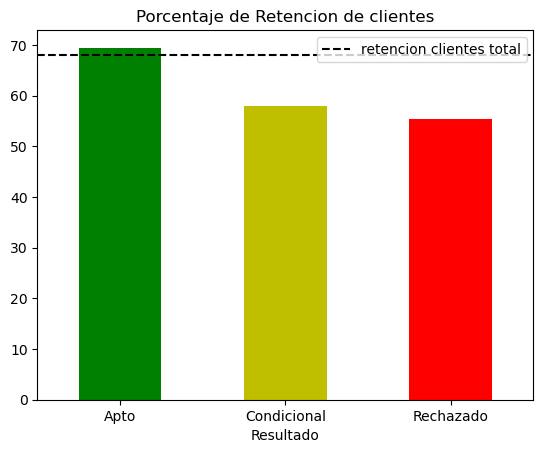

In [66]:


(retencion_clientes_pivot_taller_4_perc['retencion']*100).plot.bar( title='Porcentaje de Retencion de clientes',rot=0,color=(['g','y','r']))

plt.xticks(rotation=0)

plt.axhline(y=retencion, color='k', linestyle='--')


labels = ["retencion clientes total"]
plt.legend(labels=labels)

plt.show()